# Multiple Brain Age Clock

In [1]:
path=  'C:/Users/felip/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/'
#import sys
#sys.path.append(path) 
path_=  'C:/Users/felip/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/Brain_Age_Clock/'
import sys
sys.path.append(path_) 

# Regressor

In [2]:
from sklearn.linear_model import ElasticNet
from base_regressor import BaseRegressor
from Plotter import Plotter
from skopt.space import Real, Categorical, Integer

class ElasticNetRegressor(BaseRegressor):
    def __init__(self, save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None, fit_params_train=None, model_params_train=None, name_model="ElasticNet"):
        super().__init__(save_path, scaler, params, params_space, fit_params_search, model_params_search, fit_params_train, model_params_train, name_model)

        self.model_ml = ElasticNet
        if params is None:
            self.params = {
                'alpha': 0.2,
                'l1_ratio': 0.5,  # Proporción de L1 en la regularización
                'max_iter': 10000,
                # 'tol': 0.001
            }
        if params_space is None:
            self.params_space = {
                'alpha': Real(0.001, 10.0, prior='log-uniform'),
                'l1_ratio': Real(0.0, 1.0),  # Rango de 0 a 1 para la proporción de L1
                'max_iter': Integer(100, 10000),
                'tol': Real(1e-5, 1e-2, prior='log-uniform')
            }


c:\python_env\brain_age_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Classifier

In [3]:
from base_classifier import BaseClassifier
from Plotter import Plotter
from skopt.space import Real, Categorical, Integer
import xgboost as xgb

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold


class XGBoostClassifier(BaseClassifier):
    def __init__(self, save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None, fit_params_train=None, model_params_train=None, name_model="Lasso"):
        super().__init__(save_path, scaler, params, params_space, fit_params_search, model_params_search, fit_params_train, model_params_train, name_model)

        self.model_ml = xgb.XGBClassifier
        if params is None:
            self.params = {
            'objective': 'binary:logistic',  # Clasificación binaria
            'eval_metric': 'logloss',       # Métrica de evaluación
            'learning_rate': 0.1,           # Tasa de aprendizaje
            'max_depth': 6,                 # Profundidad máxima del árbol
            'subsample': 0.8,               # Proporción de muestras utilizadas por árbol
            'colsample_bytree': 0.8,        # Proporción de características utilizadas por árbol
            'reg_alpha': 0.1,               # Regularización L1
            'reg_lambda': 1.0,              # Regularización L2
            'gamma': 0.0,                   # Mínima reducción de pérdida para crear una división
            'min_child_weight': 1,          # Mínimo peso de la suma de los hijos para una división
            'n_estimators': 100,            # Número de árboles en el modelo
            'scale_pos_weight': 1.0         # Para datos desbalanceados
        }
        if params_space is None:
            self.params_space = {
                'objective'   : ['binary:logistic'],
                'eval_metric' : ['logloss', 'error', 'auc', 'aucpr'],
                'learning_rate': (0.01, 0.1, 0.2),
                'max_depth': (3, 4, 5),
                'subsample': (0.8, 0.9, 1.0),
                'colsample_bytree': (0.8, 0.9, 1.0),
                'reg_alpha': (0, 0.1, 1.0),
                'reg_lambda': (0, 0.1, 1.0),
                #'gamma': (0.001, 0.01, 0.1, 1, 10),
            }

# Instancia de Modelos

In [4]:
model_reg = ElasticNetRegressor()
model_cls = XGBoostClassifier()
Plotters = Plotter()

nameset ='ElasticNet'

# Data

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pickle

path_metric = f'{path}Multiple_Brain_Age_Clocks/pre_data/'


file_path_CN = f'{path_metric}CN_combined.xlsx'
file_path_AD = f'{path_metric}AD_combined.xlsx'
file_path_FTD = f'{path_metric}FTD_combined.xlsx'
file_path_MCI = f'{path_metric}MCI_combined.xlsx'

df_CN = pd.read_excel(file_path_CN)
df_AD = pd.read_excel(file_path_AD)
df_FTD = pd.read_excel(file_path_FTD)
df_MCI = pd.read_excel(file_path_MCI)

df_CN_filtrado = df_CN[(df_CN['Age'] >=50) & (df_CN['Age'] <= 90)].reset_index(drop=True)
df_AD_filtrado = df_AD[(df_AD['Age'] >= 50) & (df_AD['Age'] <= 90)].reset_index(drop=True)
df_FTD_filtrado = df_FTD[(df_FTD['Age'] >= 50) & (df_FTD['Age'] <= 90)].reset_index(drop=True)
df_MCI_filtrado = df_MCI[(df_MCI['Age'] >= 50) & (df_MCI['Age'] <= 90)].reset_index(drop=True)


In [60]:
metrics_freq = df_CN.iloc[:, 62:280].columns.tolist()
metrics_aperiodic = df_CN.iloc[:, 1:31].columns.tolist()
metrics_complex = df_CN.iloc[:, 43:52].columns.tolist()


In [61]:
#CN
X_CN_freq = df_CN_filtrado[metrics_freq]
X_CN_aperiodic= df_CN_filtrado[metrics_aperiodic]
X_CN_complex= df_CN_filtrado[metrics_complex]
X_CN = pd.concat([X_CN_freq, X_CN_aperiodic, X_CN_complex], axis=1)
y_CN = df_CN_filtrado["Age"]
ID_CN = df_CN_filtrado["ID-unique"]

#Esto es para limpiar los valores nulos
df_concatenado_CN_ = pd.concat([X_CN, y_CN, ID_CN], axis=1, ignore_index=False).dropna(axis=0) 

X_CN =df_concatenado_CN_.iloc[:, :-2]
X_CN_freq = df_concatenado_CN_[metrics_freq]
X_CN_aperiodic= df_concatenado_CN_[metrics_aperiodic]
X_CN_complex= df_concatenado_CN_[metrics_complex]
y_CN= df_concatenado_CN_.iloc[:, -2]   # Labels (Age)
ID_CN = df_concatenado_CN_.iloc[:, -1] 

#AD
X_AD_freq = df_AD_filtrado[metrics_freq]
X_AD_aperiodic= df_AD_filtrado[metrics_aperiodic]
X_AD_complex= df_AD_filtrado[metrics_complex]
X_AD = pd.concat([X_AD_freq, X_AD_aperiodic, X_AD_complex], axis=1)
y_AD = df_AD_filtrado["Age"]
ID_AD = df_AD_filtrado["ID-unique"]

df_concatenado_AD_ = pd.concat([X_AD, y_AD, ID_AD], axis=1, ignore_index=False).dropna(axis=0) 

X_AD =df_concatenado_AD_.iloc[:, :-2]
X_AD_freq = df_concatenado_AD_[metrics_freq]
X_AD_aperiodic= df_concatenado_AD_[metrics_aperiodic]
X_AD_complex= df_concatenado_AD_[metrics_complex]
y_AD= df_concatenado_AD_.iloc[:, -2]   # Labels (Age)
ID_AD = df_concatenado_AD_.iloc[:, -1] 

#FTD
X_FTD_freq = df_FTD_filtrado[metrics_freq]
X_FTD_aperiodic = df_FTD_filtrado[metrics_aperiodic]
X_FTD_complex = df_FTD_filtrado[metrics_complex]
X_FTD = pd.concat([X_FTD_freq, X_FTD_aperiodic, X_FTD_complex], axis=1)
y_FTD = df_FTD_filtrado["Age"]
ID_FTD = df_FTD_filtrado["ID-unique"]

df_concatenado_FTD_ = pd.concat([X_FTD, y_FTD, ID_FTD], axis=1, ignore_index=False).dropna(axis=0) 

X_FTD_freq = df_concatenado_FTD_[metrics_freq]
X_FTD_aperiodic = df_concatenado_FTD_[metrics_aperiodic]
X_FTD_complex = df_concatenado_FTD_[metrics_complex]
X_FTD =df_concatenado_FTD_.iloc[:, :-2]
y_FTD= df_concatenado_FTD_.iloc[:, -2]   # Labels (Age)
ID_FTD = df_concatenado_FTD_.iloc[:, -1] 

#MCI
X_MCI_freq = df_MCI_filtrado[metrics_freq]
X_MCI_aperiodic = df_MCI_filtrado[metrics_aperiodic]
X_MCI_complex = df_MCI_filtrado[metrics_complex]
X_MCI = pd.concat([X_MCI_freq, X_MCI_aperiodic, X_MCI_complex], axis=1)
y_MCI = df_MCI_filtrado["Age"]
ID_MCI = df_MCI_filtrado["ID-unique"]

df_concatenado_MCI_ = pd.concat([X_MCI, y_MCI, ID_MCI], axis=1, ignore_index=False).dropna(axis=0) 
X_MCI_freq = df_concatenado_MCI_[metrics_freq]
X_MCI_aperiodic = df_concatenado_MCI_[metrics_aperiodic]
X_MCI_complex = df_concatenado_MCI_[metrics_complex]
X_MCI =df_concatenado_MCI_.iloc[:, :-2]
y_MCI= df_concatenado_MCI_.iloc[:, -2]   # Labels (Age)
ID_MCI = df_concatenado_MCI_.iloc[:, -1] 


############################
#X_combined = pd.concat([X_CN, X_AD, X_FTD, X_MCI], axis=0).reset_index(drop=True)
scaler = StandardScaler()
scaler.fit(X_CN)

X_CN_scaled = scaler.transform(X_CN)
X_AD_scaled = scaler.transform(X_AD)
X_FTD_scaled = scaler.transform(X_FTD)
X_MCI_scaled = scaler.transform(X_MCI)

X_CN_scaled = pd.DataFrame(X_CN_scaled, columns=X_CN.columns)
X_AD_scaled = pd.DataFrame(X_AD_scaled, columns=X_AD.columns)
X_FTD_scaled = pd.DataFrame(X_FTD_scaled, columns=X_FTD.columns)
X_MCI_scaled = pd.DataFrame(X_MCI_scaled, columns=X_MCI.columns)



####################################
df_concatenado_CN = pd.concat([X_CN, y_CN, ID_CN], axis=1, ignore_index=False)
df_concatenado_AD = pd.concat([X_AD, y_AD, ID_AD], axis=1, ignore_index=False)
df_concatenado_FTD = pd.concat([X_FTD, y_FTD, ID_FTD], axis=1, ignore_index=False)
df_concatenado_MCI = pd.concat([X_MCI, y_MCI, ID_MCI], axis=1, ignore_index=False)

df_patient = [df_concatenado_AD, df_concatenado_FTD, df_concatenado_MCI]

In [9]:
import pandas as pd

# Nombres de las regiones
nombres_regiones = [
    'OCC_left', 'OCC_right', 'HPC_left', 'HPC_right', 
    'PARIET_left', 'PARIET_right', 'CING_left', 'CING_right', 
    'ORB_left', 'ORB_right', 'INS_left', 'INS_right', 
    'IFG_left', 'IFG_right', 'SFG_left', 'SFG_right', 
    'MFG_left', 'MFG_right','TEMP_left','TEMP_right'
]

# Filtrado Metricas

Seleccion de metricas

In [ ]:
# Crear un diccionario para almacenar las columnas por región
columnas_por_region = {}

for region in nombres_regiones:
    # Filtrar columnas que contienen el nombre de la región
    columnas_por_region[region] = [col for col in X_CN.columns if region in col]

# Ver el resultado
for region, columnas in columnas_por_region.items():
    print(f"Región: {region}")
    print(f"Columnas: {columnas}\n")


# Hyperparameter Tunning

Busqueda de hiperparametros

In [100]:
scaler = StandardScaler()
scaler.fit(X_CN)
X_CN_scaled = scaler.transform(X_CN)
X_CN_scaled = pd.DataFrame(X_CN_scaled, columns=X_CN.columns)


# Listas para almacenar los modelos y los mejores parámetros
opt_models = {}
best_params = {}

# Iterar sobre las regiones
for region in nombres_regiones:
    columnas_region = columnas_por_region[region]
    
    opt_model, best_params_region = model_reg.search_best_model(
        X=X_CN_scaled, 
        y=y_CN, 
        n_iter_=10, 
        scoring_metric='r2'
    )
    
    # Agregar los resultados a las listas
    opt_models[region] = opt_model
    best_params[region] = best_params_region

    print(f"Modelo y parámetros para {region} procesados.")  # Seguimiento del progreso

# Mostrar un resumen
print("Procesamiento completado.")
print(f"Se ajustaron {len(opt_models)} modelos.")


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Modelo y parámetros para OCC_left procesados.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidat

In [101]:
best_params

{'OCC_left': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.9200092264373164,
  'max_iter': 5015,
  'tol': 0.0032581367701603925},
 'OCC_right': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.9200092264373164,
  'max_iter': 5015,
  'tol': 0.0032581367701603925},
 'HPC_left': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.9200092264373164,
  'max_iter': 5015,
  'tol': 0.0032581367701603925},
 'HPC_right': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.9200092264373164,
  'max_iter': 5015,
  'tol': 0.0032581367701603925},
 'PARIET_left': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.9200092264373164,
  'max_iter': 5015,
  'tol': 0.0032581367701603925},
 'PARIET_right': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.9200092264373164,
  'max_iter': 5015,
  'tol': 0.0032581367701603925},
 'CING_left': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.9200092264373164,
  'max_iter': 5015,
  'tol': 0.0032581367701603925},
 'CING_right': {'alpha': 0.14914622679778672,
  'l1_ratio': 0.92000922643

# Trainer

Entrenamiento con controles

In [ ]:
# Diccionarios para almacenar los resultados de cada región
results_labels_CN_train = {}
results_labels_CN_test = {}
results_models = {}
results_folds_CN_train = {}
results_folds_CN_test = {}
results_avg_CN_train = {}
results_avg_CN_test = {}

# Iterar sobre las regiones
for region in nombres_regiones:
    # Obtener las columnas correspondientes a la región
    columnas_region = columnas_por_region[region]
    
    # Obtener los mejores parámetros para la región
    best_params_region = best_params[region]
    
    # Entrenar el modelo con `trainer_2`
    results_labels_CN_train[region], results_labels_CN_test[region], results_models[region], \
    results_folds_CN_train[region], results_folds_CN_test[region],\
         results_avg_CN_train[region],results_avg_CN_test[region] = model_reg.trainer(
        X=X_CN[columnas_region],
        y=y_CN,
        ID=ID_CN,
        ID_label = 'ID-unique',
        n_splits=10,
        n_iterations=20,
        params_=best_params_region
    )
    
    print(f"Modelo entrenado para la región {region}.")  # Seguimiento del progreso

# Mostrar un resumen
print("Entrenamiento completado para todas las regiones.")


# Patient Test

Testeo en pacientes

In [ ]:
# Diccionarios para almacenar resultados por región y paciente
results_labels_test_Patient = {'AD': {}, 'FTD': {}, 'MCI': {}}
results_folds_test_Patient = {'AD': {}, 'FTD': {}, 'MCI': {}}
results_avg_test_Patient = {'AD': {}, 'FTD': {}, 'MCI': {}}

# Iterar sobre las regiones
for region in nombres_regiones:
    columnas_region = columnas_por_region[region]
    modelo_region = results_models[region]
    
    # Test para pacientes AD
    results_labels_test_Patient['AD'][region], results_folds_test_Patient['AD'][region], results_avg_test_Patient['AD'][region] = model_reg.test(
        X=X_AD[columnas_region],
        y=y_AD,
        ID_label='ID-unique',
        ID=ID_AD,
        n_splits=10,
        n_iterations=20,
        result_model=modelo_region
    )
    
    # Test para pacientes FTD
    results_labels_test_Patient['FTD'][region], results_folds_test_Patient['FTD'][region], results_avg_test_Patient['FTD'][region] = model_reg.test(
        X=X_FTD[columnas_region],
        y=y_FTD,
        ID_label='ID-unique',
        ID=ID_FTD,
        n_splits=10,
        n_iterations=20,
        result_model=modelo_region
    )
    
    # Test para pacientes MCI
    results_labels_test_Patient['MCI'][region], results_folds_test_Patient['MCI'][region], results_avg_test_Patient['MCI'][region] = model_reg.test(
        X=X_MCI[columnas_region],
        y=y_MCI,
        ID_label='ID-unique',
        ID=ID_MCI,
        n_splits=10,
        n_iterations=20,
        result_model=modelo_region
    )
    
    print(f"Pruebas realizadas para la región {region}.")  # Seguimiento del progreso

# Mostrar un resumen
print("Pruebas completadas para todas las regiones y pacientes.")


# Multiples Clocks

Concatenación de multiples relojes

In [40]:
import pandas as pd

def merge_regiones_por_grupo(df_base, resultados_regiones, nombres_regiones):
   
    df_resultado = df_base.copy()  # Hacemos una copia para no modificar el original

    for region in nombres_regiones:
        # Verificar si la región existe en el diccionario de resultados
        if region in resultados_regiones:
            # Seleccionar y renombrar columnas
            temp_df = resultados_regiones[region][['ID-unique', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected']].rename(
                columns={
                    'y_pred': f'y_pred_{region}',
                    'y_pred_corrected': f'y_pred_corrected_{region}',
                    'GAP': f'GAP_{region}',
                    'GAP_corrected': f'GAP_corrected_{region}'
                }
            )
            # Merge con el DataFrame base
            df_resultado = pd.merge(
                df_resultado,
                temp_df,
                on='ID-unique',
                how='inner'
            )
        else:
            print(f"Advertencia: La región '{region}' no se encuentra en los resultados.")

    return df_resultado


In [44]:
df_base_CN = df_concatenado_CN.iloc[:, -2:]  # DataFrame base para CN
resultados_regiones_CN = results_avg_CN_test  # Diccionario con resultados para las regiones

df_results_clocks_CN = merge_regiones_por_grupo(df_base_CN, resultados_regiones_CN, nombres_regiones)

df_base_AD = df_concatenado_AD.iloc[:, -2:]
df_results_clocks_AD = merge_regiones_por_grupo(df_base_AD, results_avg_test_Patient['AD'], nombres_regiones)

df_base_FTD = df_concatenado_FTD.iloc[:, -2:]
df_results_clocks_FTD = merge_regiones_por_grupo(df_base_FTD, results_avg_test_Patient['FTD'], nombres_regiones)


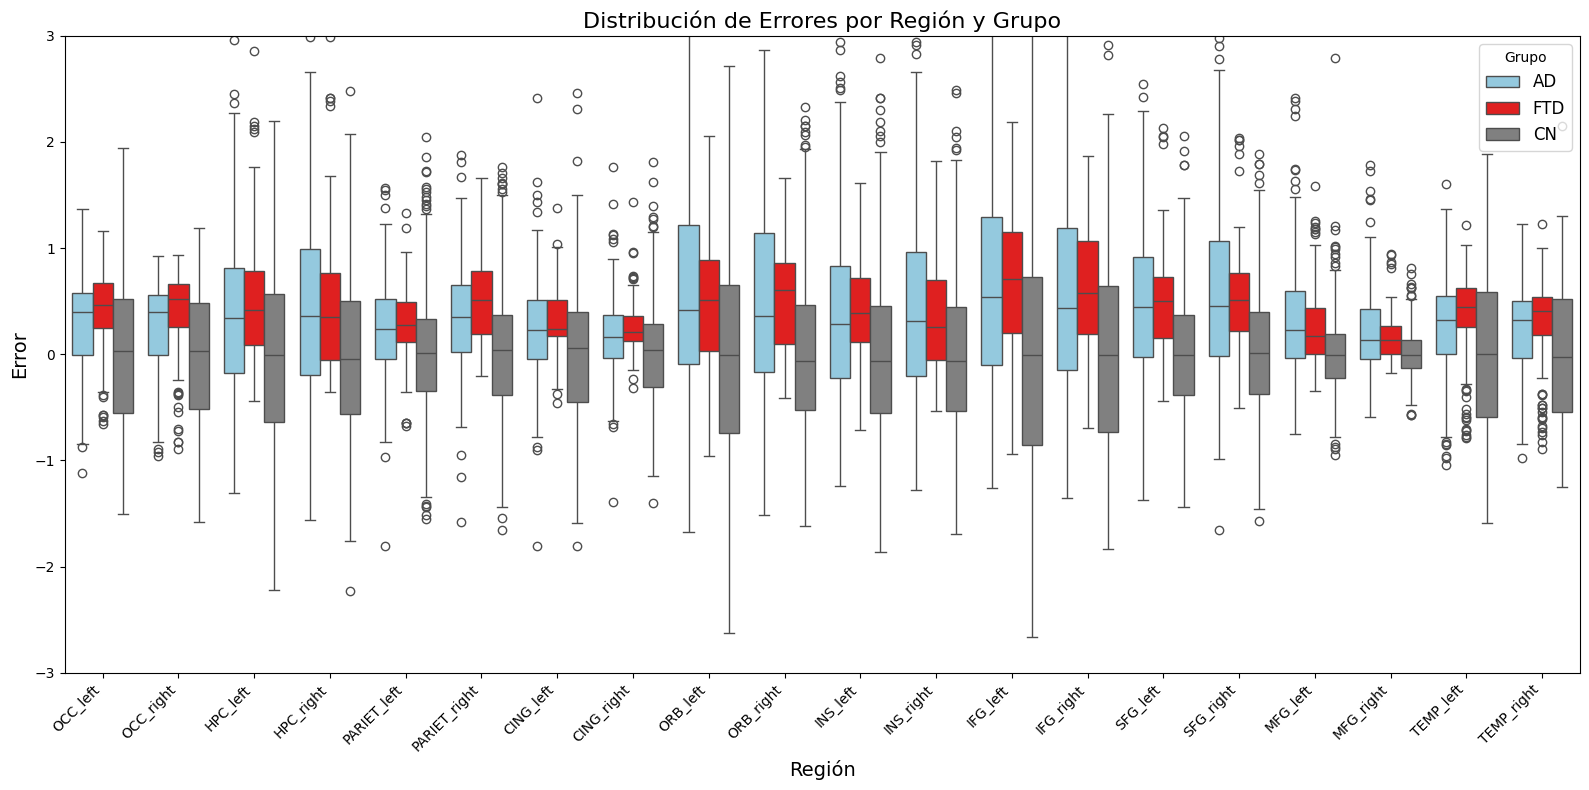

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Colores personalizados para cada grupo
colores_personalizados = {
    'AD': 'skyblue',
    'FTD': 'red',
    #'MCI': 'lightgreen',
    'CN': 'gray'
}

# Inicializar un dataframe vacío para concatenar los resultados de todas las regiones
all_regions_data = []

for region in nombres_regiones:
    # Extraer los valores corregidos de GAP para cada grupo
    corrected_gap_AD = pd.to_numeric(results_avg_test_Patient['AD'][region]['GAP_corrected'])
    corrected_gap_FTD = pd.to_numeric(results_avg_test_Patient['FTD'][region]['GAP_corrected'])
    #corrected_gap_MCI = pd.to_numeric(results_avg_test_Patient[region]['GAP_corrected'])
    corrected_gap_CN_test = pd.to_numeric(results_avg_CN_test[region]['GAP_corrected'])

    # Crear el DataFrame en formato largo
    data = {
        'Error': np.concatenate([corrected_gap_AD, corrected_gap_FTD, corrected_gap_CN_test]),
        'Grupo': (['AD'] * len(corrected_gap_AD) +
                  ['FTD'] * len(corrected_gap_FTD) +
                  #['MCI'] * len(corrected_gap_MCI) +
                  ['CN'] * len(corrected_gap_CN_test)),
        'Región': [region] * (
            len(corrected_gap_AD) +
            len(corrected_gap_FTD) +
            #len(corrected_gap_MCI) +
            len(corrected_gap_CN_test)
        )
    }

    df_errors = pd.DataFrame(data)
    all_regions_data.append(df_errors)

# Concatenar todos los datos en un solo DataFrame
final_df = pd.concat(all_regions_data, ignore_index=True)

# Crear el gráfico de boxplot con colores personalizados
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=final_df,
    x='Región',
    y='Error',
    hue='Grupo',
    palette=colores_personalizados  # Aplicar colores personalizados
)
plt.title('Distribución de Errores por Región y Grupo', fontsize=16)
plt.xlabel('Región', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.ylim(-3,3)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Grupo', fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()


# Pipeline Regression

In [77]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def pipeline_regression_clocks(df_concatenado_CN, df_concatenado_pacientes, nombres_regiones, model_reg):
    # --------------------------- 1. Selección de Métricas ---------------------------
    columnas_por_region = {}
    X_CN = df_concatenado_CN.iloc[:, :-2]
    y_CN = df_concatenado_CN.iloc[:, -2]
    ID_CN = df_concatenado_CN.iloc[:, -1]
    
    for region in nombres_regiones:
        columnas_por_region[region] = [col for col in X_CN.columns if region in col]

    # --------------------------- 2. Búsqueda de Hiperparámetros ---------------------------
    scaler = StandardScaler()
    X_CN_scaled = pd.DataFrame(scaler.fit_transform(X_CN), columns=X_CN.columns)

    opt_models = {}
    best_params = {}
    for region in nombres_regiones:
        columnas_region = columnas_por_region[region]
        if not columnas_region:
            continue

        opt_model, best_params_region = model_reg.search_best_model(
            X=X_CN_scaled[columnas_por_region[region]], y=y_CN, n_iter_=10, scoring_metric='r2'
        )
        opt_models[region] = opt_model
        best_params[region] = best_params_region

    # --------------------------- 3. Entrenamiento con Controles ---------------------------
    results_labels_CN_train = {}
    results_labels_CN_test = {}
    results_models = {}
    results_folds_CN_train = {}
    results_folds_CN_test = {}
    results_avg_CN_train = {}
    results_avg_CN_test = {}

    for region in nombres_regiones:
        
        columnas_region = columnas_por_region[region]
        
        if not columnas_region:
            continue

        best_params_region = best_params[region]

        results_labels_CN_train[region], results_labels_CN_test[region], results_models[region], \
        results_folds_CN_train[region], results_folds_CN_test[region], results_avg_CN_train[region], \
        results_avg_CN_test[region] = model_reg.trainer(
            X=X_CN[columnas_region], y=y_CN, ID=ID_CN, ID_label='ID-unique',
            n_splits=10, n_iterations=20, params_=best_params_region
        )

    # --------------------------- 4. Testeo en Pacientes ---------------------------
    results_labels_test_Patient = {'AD': {}, 'FTD': {}}
    results_folds_test_Patient = {'AD': {}, 'FTD': {}}
    results_avg_test_Patient = {'AD': {}, 'FTD': {}}

    for region in nombres_regiones:
        columnas_region = columnas_por_region[region]
        if not columnas_region:
            continue
        modelo_region = results_models[region]

        for grupo, df_paciente in zip(['AD', 'FTD'], df_concatenado_pacientes):
            X_patient = df_paciente.iloc[:, :-2]
            y_patient = df_paciente.iloc[:, -2]
            ID_patient = df_paciente.iloc[:, -1]
            
            results_labels_test_Patient[grupo][region], results_folds_test_Patient[grupo][region], \
            results_avg_test_Patient[grupo][region] = model_reg.test(
                X=X_patient[columnas_region], y=y_patient, ID_label='ID-unique',
                ID=ID_patient, n_splits=10, n_iterations=20, result_model=modelo_region
            )

    # --------------------------- 5. Concatenación de Resultados ---------------------------
    def merge_regiones_por_grupo(df_base, resultados_regiones, nombres_regiones):
        df_resultado = df_base.copy()
        for region in nombres_regiones:
            if region in resultados_regiones:
                temp_df = resultados_regiones[region][['ID-unique', 'y_pred', 'y_pred_corrected', 
                                                       'GAP', 'GAP_corrected']].rename(
                    columns={
                        'y_pred': f'y_pred_{region}',
                        'y_pred_corrected': f'y_pred_corrected_{region}',
                        'GAP': f'GAP_{region}',
                        'GAP_corrected': f'GAP_corrected_{region}'
                    }
                )
                df_resultado = pd.merge(df_resultado, temp_df, on='ID-unique', how='inner')
        return df_resultado
    
    df_base_CN = df_concatenado_CN.iloc[:, -2:]
    df_results_clocks_CN = merge_regiones_por_grupo(df_base_CN, results_avg_CN_test, nombres_regiones)

    df_base_AD = df_concatenado_pacientes[0].iloc[:, -2:]
    df_results_clocks_AD = merge_regiones_por_grupo(df_base_AD, results_avg_test_Patient['AD'], nombres_regiones)

    df_base_FTD = df_concatenado_pacientes[1].iloc[:, -2:]
    df_results_clocks_FTD = merge_regiones_por_grupo(df_base_FTD, results_avg_test_Patient['FTD'], nombres_regiones)

    

    # --------------------------- Resultado Final ---------------------------
    return (
        columnas_por_region,
        (opt_models, best_params),
        (results_labels_CN_train, results_labels_CN_test, results_models, results_folds_CN_train, 
         results_folds_CN_test, results_avg_CN_train, results_avg_CN_test),
        (results_labels_test_Patient, results_folds_test_Patient, results_avg_test_Patient),
        (df_results_clocks_CN, df_results_clocks_AD, df_results_clocks_FTD)
    )


In [ ]:
# Concatenar los dataframes como entrada
df_concatenado_CN = pd.concat([X_CN_aperiodic, y_CN, ID_CN], axis=1, ignore_index=False)
df_concatenado_AD = pd.concat([X_AD_aperiodic, y_AD, ID_AD], axis=1, ignore_index=False)
df_concatenado_FTD = pd.concat([X_FTD_aperiodic, y_FTD, ID_FTD], axis=1, ignore_index=False)

df_concatenado_pacientes = [df_concatenado_AD, df_concatenado_FTD]

# Nombres de las regiones
nombres_regiones = [
    'OCC_left', 'OCC_right', 'HPC_left', 'HPC_right', 
    'PARIET_left', 'PARIET_right', 'CING_left', 'CING_right', 
    'ORB_left', 'ORB_right', 'INS_left', 'INS_right', 
    'IFG_left', 'IFG_right', 'SFG_left', 'SFG_right', 
    'MFG_left', 'MFG_right','TEMP_left','TEMP_right'
]

# Llamar a la función
resultados = pipeline_regression_clocks(
    df_concatenado_CN=df_concatenado_CN, 
    df_concatenado_pacientes=df_concatenado_pacientes, 
    nombres_regiones=nombres_regiones,
    model_reg=model_reg  # Debe estar definido en tu entorno
)

# Desempaquetar resultados
(columnas_por_region, 
 (opt_models, best_params), 
 (results_labels_CN_train, results_labels_CN_test, results_models, 
  results_folds_CN_train, results_folds_CN_test, results_avg_CN_train, results_avg_CN_test),
 (results_labels_test_Patient, results_folds_test_Patient, results_avg_test_Patient),
 (df_results_clocks_CN, df_results_clocks_AD, df_results_clocks_FTD)) = resultados


In [ ]:
# Concatenar los dataframes como entrada
df_concatenado_CN = pd.concat([X_CN, y_CN, ID_CN], axis=1, ignore_index=False)
df_concatenado_AD = pd.concat([X_AD, y_AD, ID_AD], axis=1, ignore_index=False)
df_concatenado_FTD = pd.concat([X_FTD, y_FTD, ID_FTD], axis=1, ignore_index=False)

df_concatenado_pacientes = [df_concatenado_AD, df_concatenado_FTD]

# Nombres de las regiones
nombres_regiones = [
    'OCC_left', 'OCC_right', 'HPC_left', 'HPC_right', 
    'PARIET_left', 'PARIET_right', 'CING_left', 'CING_right', 
    'ORB_left', 'ORB_right', 'INS_left', 'INS_right', 
    'IFG_left', 'IFG_right', 'SFG_left', 'SFG_right', 
    'MFG_left', 'MFG_right','TEMP_left','TEMP_right'
]

# Llamar a la función
resultados = pipeline_regression_clocks(
    df_concatenado_CN=df_concatenado_CN, 
    df_concatenado_pacientes=df_concatenado_pacientes, 
    nombres_regiones=nombres_regiones,
    model_reg=model_reg  # Debe estar definido en tu entorno
)

# Desempaquetar resultados
(columnas_por_region, 
 (opt_models, best_params), 
 (results_labels_CN_train, results_labels_CN_test, results_models, 
  results_folds_CN_train, results_folds_CN_test, results_avg_CN_train, results_avg_CN_test),
 (results_labels_test_Patient, results_folds_test_Patient, results_avg_test_Patient),
 (df_results_clocks_CN, df_results_clocks_AD, df_results_clocks_FTD)) = resultados


In [66]:
def combinar_resultados(df_base, df_resultados, df_seleccionado, columnas_extra):
   
    df_seleccionado = df_seleccionado[['ID-unique'] + columnas_extra]
    df_combinado = df_resultados.merge(df_seleccionado, on='ID-unique', how='left')
    return df_combinado

columnas_extra = ['Country_ID', 'Sex', 'Educ', 'MMSE', 'GINI', 'ODQ']

df_CN_combined_clocks = combinar_resultados(df_results_clocks_CN, df_results_clocks_CN, df_CN_filtrado, columnas_extra)
df_AD_combined_clocks = combinar_resultados(df_results_clocks_AD, df_results_clocks_AD, df_AD_filtrado, columnas_extra)
df_FTD_combined_clocks = combinar_resultados(df_results_clocks_FTD, df_results_clocks_FTD, df_FTD_filtrado, columnas_extra)

df_CN_combined_clocks.to_excel('results/df_CN_results_clocks_freq_aperiodic_complex.xlsx', index=False)
df_AD_combined_clocks.to_excel('results/df_AD_results_clocks_freq_aperiodic_complex.xlsx', index=False)
df_FTD_combined_clocks.to_excel('results/df_FTD_results_clocks_freq_aperiodic_complex.xlsx', index=False)
#df_MCI_combined.to_excel('results/df_MCI_results_all_features.xlsx', index=False)

# Clasificación

In [98]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def pipeline_model_training(file_paths, model_cls, n_iter_=30, scoring_metric='accuracy', 
                            n_splits=10, n_iterations=20, scaler_type=3, test_size=0.5, random_state=42):
    
    # Leer archivos Excel y agregar Diagnosis
    df_CN_results_ = pd.read_excel(file_paths['CN'])
    df_AD_results_ = pd.read_excel(file_paths['AD'])
    df_FTD_results_ = pd.read_excel(file_paths['FTD'])
    
    # Agregar la columna Diagnosis
    df_CN_results_['Diagnosis'] = 0  # CN
    df_AD_results_['Diagnosis'] = 1  # AD
    df_FTD_results_['Diagnosis'] = 1  # FTD
    
    # Extraer columnas GAP_corrected
    gap_corrected_columns = [col for col in df_CN_results_.columns if 'GAP_corrected' in col]
    
    # Combinar datasets
    df_results_combined = pd.concat([df_CN_results_, df_AD_results_, df_FTD_results_], ignore_index=True)
    df_results_combined['ID-unique-2'] = range(len(df_results_combined))
        
    # Variables X, y e id
    X_ = df_results_combined[gap_corrected_columns]
    y_ = df_results_combined['Diagnosis']
    id_ = df_results_combined['ID-unique-2']

    # Crear dataframe concatenado
    df_concatenado = pd.concat([pd.DataFrame(X_, columns=gap_corrected_columns), 
                                y_, id_], axis=1, ignore_index=False)
    
    # Dividir en entrenamiento y prueba
    df_train, df_test = train_test_split(
        df_concatenado, test_size=test_size, random_state=random_state, stratify=df_concatenado['Diagnosis']
    )    
    # Combinar nuevamente para obtener dataset desordenado
    df_desordenado = pd.concat([df_train, df_test]).reset_index(drop=True)
    
    X = df_desordenado[gap_corrected_columns]
    y = df_desordenado['Diagnosis']
    id = df_desordenado['ID-unique-2']

    # Escalado
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    
    # Buscar mejores hiperparámetros
    opt_model_cls, best_params_cls = model_cls.search_best_model(
        X=X_scaled, y=y, 
        n_iter_=n_iter_, scoring_metric=scoring_metric
    )
    
    # Entrenar modelo
    results_labels_df_train, results_labels_df_test, results_model, \
    results_per_fold_train, results_per_fold_test = model_cls.trainer(
        X=X, y=y, ID = id, ID_label= 'ID-unique-2', n_splits=n_splits, n_iterations=n_iterations, 
        params_=best_params_cls, scaler=scaler_type)
    
    return (opt_model_cls, results_labels_df_train, results_labels_df_test, 
            results_model, results_per_fold_train, results_per_fold_test)


In [99]:
file_paths = {
    'CN': 'results/df_CN_results_clocks_freq_aperiodic_complex.xlsx',
    'AD': 'results/df_AD_results_clocks_freq_aperiodic_complex.xlsx',
    'FTD': 'results/df_FTD_results_clocks_freq_aperiodic_complex.xlsx'
}

# Llamada a la función
results = pipeline_model_training(
    file_paths=file_paths,
    model_cls=model_cls,
    n_iter_=30,
    scoring_metric='accuracy',
    n_splits=10,
    n_iterations=20,
    scaler_type=3
)

# Desempaquetar resultados
opt_model_cls, results_labels_df_train, results_labels_df_test, results_model, results_per_fold_train, results_per_fold_test = results


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

c:\Users\felip\OneDrive - Universidad Técnica Federico Santa María\Documentos\Brain\Brain_Age_Clock\base_classifier.py:195: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_train = pd.concat([results_labels_df_train, temp_df_train], ignore_index=True)
c:\Users\felip\OneDrive - Universidad Técnica Federico Santa María\Documentos\Brain\Brain_Age_Clock\base_classifier.py:197: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_test = pd.concat([results_labels_df_test, tem